In [2]:
#상위 폴더 load_data파일 불러오기 위해 경로 추가
import sys
sys.path.append('../')  # 상위 폴더(main_folder)의 경로를 추가

# 데이터 가져오기
from load_data import load_data

# 사용자 지정 함수 불러오기
from eval import get_Accuracy_tf

# 텐서플로
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as Layer

# 콜백
from timeit import default_timer as timer

In [3]:
# 랜덤시드 고정
tf.random.set_seed(42)

In [4]:
# MinMaxScaler - 0, StandardScaler - 1, , MaxAbsScaler - 2, RobustScaler - 3, Normalizer - 4
X_train0, X_val0, X_test0, y_train0, y_val0, y_test0, scaler0  = load_data(scaler=0)
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1, scaler1  = load_data(scaler=1)
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2, scaler2  = load_data(scaler=2)
X_train3, X_val3, X_test3, y_train3, y_val3, y_test3, scaler3  = load_data(scaler=3)
X_train4, X_val4, X_test4, y_train4, y_val4, y_test4, scaler4  = load_data(scaler=4)

X_train1.shape, X_val1.shape, X_test2.shape, y_train2.shape, y_val2.shape, y_test2.shape, scaler2



((2672, 10), (669, 10), (836, 10), (2672,), (669,), (836,), MaxAbsScaler())

In [11]:
class EvalAccuracy(tf.keras.metrics.Metric):
    """
    사용자 정의 평가지표 : Accuracy
    """
    def __init__(self, name="accuracy", **kwargs):
        super(EvalAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name=name, initializer="zeros")

    def update_state(self, y_true, y_predict, sample_weight=None):
        value = tf.abs((y_predict - y_true) / y_true)
        self.correct.assign(tf.reduce_mean(value))

    def result(self):
        return 1 - self.correct

    def reset_state(self):
        self.correct.assign(0.)

def get_model(shape=len(X_train0.columns), node_n=12, dout=0.001):
    inputs  = keras.Input(shape=shape)
    
    dense1  = keras.layers.Dense(12)(inputs)
    norm1   = keras.layers.BatchNormalization()(dense1)
    relu1   = keras.layers.Activation('relu')(norm1)
    dout1   = keras.layers.Dropout(dout)(relu1)
    
    dense2  = keras.layers.Dense(10)(dout1)
    norm2   = keras.layers.BatchNormalization()(dense2)
    relu2   = keras.layers.Activation('relu')(norm2)
    dout2   = keras.layers.Dropout(dout)(relu2)
    
    dense3  = keras.layers.Dense(8)(dout2)
    norm3   = keras.layers.BatchNormalization()(dense3)
    relu3   = keras.layers.Activation('relu')(norm3)
    dout3   = keras.layers.Dropout(dout)(relu3)
    
    dense4  = keras.layers.Dense(6)(dout3)
    norm4   = keras.layers.BatchNormalization()(dense4)
    relu4   = keras.layers.Activation('relu')(norm4)
    dout4   = keras.layers.Dropout(dout)(relu4)
    
    dense5  = keras.layers.Dense(4)(dout4)
    norm5   = keras.layers.BatchNormalization()(dense5)
    relu5   = keras.layers.Activation('relu')(norm5)
    dout5   = keras.layers.Dropout(dout)(relu5)
    
    concat1  = keras.layers.Concatenate(axis=1)([dout5, dout4])
    dense6  = keras.layers.Dense(6)(concat1)
    norm6   = keras.layers.BatchNormalization()(dense6)
    relu6   = keras.layers.Activation('relu')(norm6)
    dout6   = keras.layers.Dropout(dout)(relu6)
    
    concat2  = keras.layers.Concatenate(axis=1)([dout6, dout3])
    dense7  = keras.layers.Dense(8)(concat2)
    norm7   = keras.layers.BatchNormalization()(dense7)
    relu7   = keras.layers.Activation('relu')(norm7)
    dout7   = keras.layers.Dropout(dout)(relu7)
    
    concat3  = keras.layers.Concatenate(axis=1)([dout7, dout2])
    dense8  = keras.layers.Dense(10)(concat3)
    norm8   = keras.layers.BatchNormalization()(dense8)
    relu8   = keras.layers.Activation('relu')(norm8)
    dout8   = keras.layers.Dropout(dout)(relu8)
    
    concat4  = keras.layers.Concatenate(axis=1)([dout8, dout1])
    dense9  = keras.layers.Dense(12)(concat4)
    norm9   = keras.layers.BatchNormalization()(dense9)
    relu9   = keras.layers.Activation('relu')(norm9)
    dout9   = keras.layers.Dropout(dout)(relu9)
    
    outputs = keras.layers.Dense(1)(dout9)
    model   = keras.Model(inputs, outputs, name='Abalone_Model')
    
    model.compile(
        optimizer=keras.optimizers.Adam(0.01),
        loss=keras.losses.MeanSquaredError(),
        metrics=[EvalAccuracy()]
        )
    return model

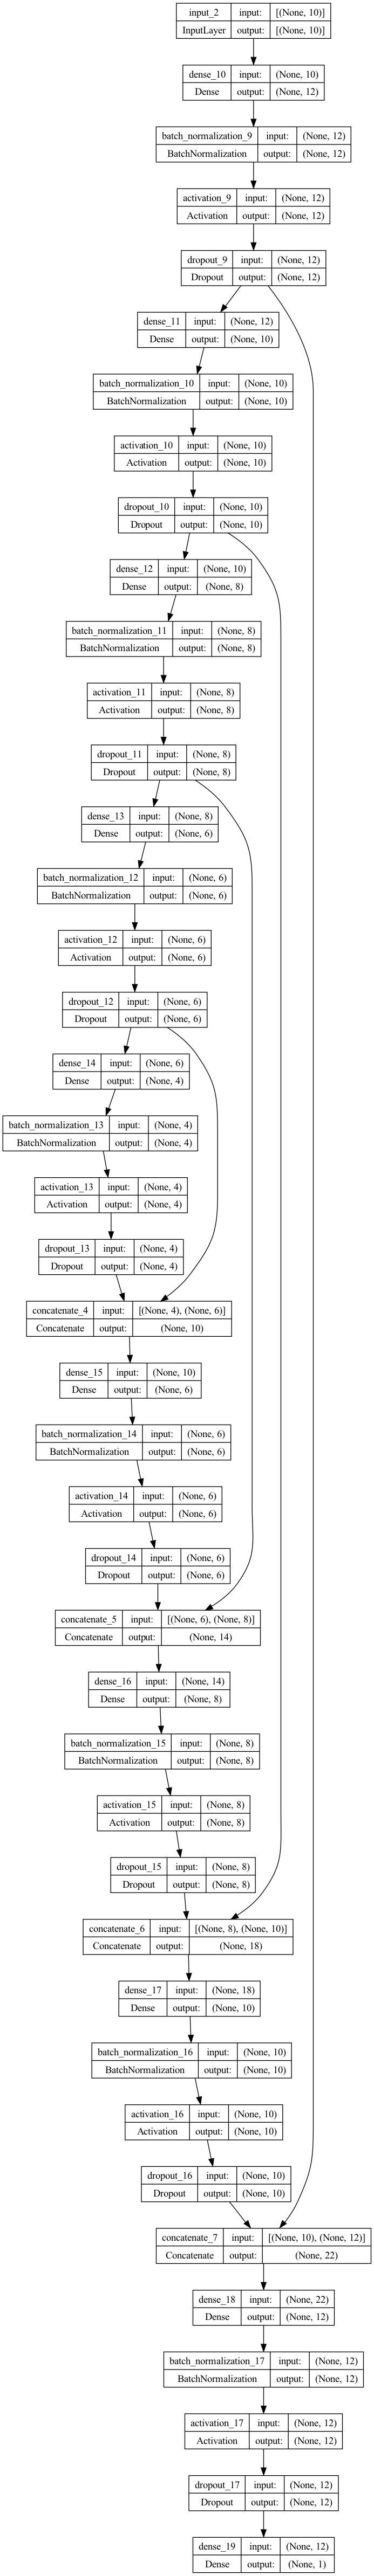

In [12]:
model = get_model()
keras.utils.plot_model(model, show_shapes=True)

In [13]:

# 학습 소요 시간 표시 콜백용 class 정의
class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting training")
        self.starttime = timer()

    def on_train_end(self, logs=None):
        print("End of training, took {} seconds".format(timer()-self.starttime))

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
          print("Epoch is {} and {} seconds passed".format(epoch, timer()-self.starttime))

In [14]:
check_path = 'model_weight.h5'

callback = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50),
    tf.keras.callbacks.ModelCheckpoint(filepath=check_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=200, min_lr=0.001),
    TimingCallback()
]

In [15]:
history0 = model.fit(X_train0, y_train0, batch_size= 1024, epochs= 1000,  validation_data=(X_val0, y_val0), callbacks=callback,verbose = 0)
results0 = model.evaluate(X_test0, y_test0)

Starting training
Epoch is 0 and 1.031147165922448 seconds passed
Epoch is 10 and 1.3546752908732742 seconds passed
Epoch is 20 and 1.6568224160000682 seconds passed
Epoch is 30 and 1.9433340409304947 seconds passed
Epoch is 40 and 2.1511660828255117 seconds passed
Epoch is 50 and 2.3385532908141613 seconds passed
Epoch is 60 and 2.538978915894404 seconds passed
Epoch is 70 and 2.766960624838248 seconds passed
Epoch is 80 and 2.9587097079493105 seconds passed
Epoch is 90 and 3.1472129998728633 seconds passed
Epoch is 100 and 3.337608583038673 seconds passed
Epoch is 110 and 3.5266306248959154 seconds passed
End of training, took 3.6546001250389963 seconds
27/27 [==============================] - 0s 493us/step - loss: 7.9238 - accuracy: 0.8642


In [16]:
history1 = model.fit(X_train1, y_train1, batch_size= 1024, epochs= 1000,  validation_data=(X_val1, y_val1), callbacks=callback,verbose = 0)
results1 = model.evaluate(X_test1, y_test1)

Starting training
Epoch is 0 and 0.043612292036414146 seconds passed
Epoch is 10 and 0.23931337497197092 seconds passed
Epoch is 20 and 0.44189620902761817 seconds passed
Epoch is 30 and 0.6302318340167403 seconds passed
Epoch is 40 and 0.8240180001594126 seconds passed
Epoch is 50 and 1.0628287091385573 seconds passed
Epoch is 60 and 1.2718158341012895 seconds passed
Epoch is 70 and 1.4875292091164738 seconds passed
Epoch is 80 and 1.7040802920237184 seconds passed
Epoch is 90 and 1.921447625150904 seconds passed
Epoch is 100 and 2.106066834181547 seconds passed
Epoch is 110 and 2.313799250172451 seconds passed
Epoch is 120 and 2.530050584115088 seconds passed
Epoch is 130 and 2.715253584086895 seconds passed
Epoch is 140 and 2.9088465000968426 seconds passed
Epoch is 150 and 3.118204209022224 seconds passed
Epoch is 160 and 3.3326610419899225 seconds passed
Epoch is 170 and 3.521620917133987 seconds passed
Epoch is 180 and 3.712594292126596 seconds passed
Epoch is 190 and 3.915518125

In [17]:
history2 = model.fit(X_train2, y_train2, batch_size= 1024, epochs= 1000,  validation_data=(X_val2, y_val2), callbacks=callback,verbose = 0)
results2 = model.evaluate(X_test2, y_test2)

Starting training
Epoch is 0 and 0.04566895798780024 seconds passed
Epoch is 10 and 0.24013691698201 seconds passed
Epoch is 20 and 0.4315443751402199 seconds passed
Epoch is 30 and 0.6161066249478608 seconds passed
Epoch is 40 and 0.8005099999718368 seconds passed
Epoch is 50 and 0.9895070421043783 seconds passed
Epoch is 60 and 1.1865999170113355 seconds passed
End of training, took 1.2866190001368523 seconds
27/27 [==============================] - 0s 470us/step - loss: 17.5761 - accuracy: 0.3356


In [18]:
history3 = model.fit(X_train3, y_train3, batch_size= 1024, epochs= 1000,  validation_data=(X_val3, y_val3), callbacks=callback,verbose = 0)
results3 = model.evaluate(X_test3, y_test3)

Starting training
Epoch is 0 and 0.04386541713029146 seconds passed
Epoch is 10 and 0.2288919580169022 seconds passed
Epoch is 20 and 0.41221574996598065 seconds passed
Epoch is 30 and 0.599847000092268 seconds passed
Epoch is 40 and 0.7803589170798659 seconds passed
Epoch is 50 and 0.9650985421612859 seconds passed
Epoch is 60 and 1.1453377921134233 seconds passed
Epoch is 70 and 1.3285199999809265 seconds passed
Epoch is 80 and 1.5200512921437621 seconds passed
Epoch is 90 and 1.719904167111963 seconds passed
Epoch is 100 and 1.9115652500186116 seconds passed
Epoch is 110 and 2.106665916973725 seconds passed
Epoch is 120 and 2.2932447500061244 seconds passed
Epoch is 130 and 2.4794560000300407 seconds passed
Epoch is 140 and 2.660502125043422 seconds passed
Epoch is 150 and 2.843752667075023 seconds passed
Epoch is 160 and 3.02563179214485 seconds passed
End of training, took 3.1896970830857754 seconds
27/27 [==============================] - 0s 474us/step - loss: 7.1839 - accuracy: 

In [19]:
history4 = model.fit(X_train4, y_train4, batch_size= 1024, epochs= 1000,  validation_data=(X_val4, y_val4), callbacks=callback,verbose = 0)
results4 = model.evaluate(X_test4, y_test4)

Starting training
Epoch is 0 and 0.04211441706866026 seconds passed
Epoch is 10 and 0.2369880829937756 seconds passed
Epoch is 20 and 0.4263569170143455 seconds passed
Epoch is 30 and 0.615969292121008 seconds passed
Epoch is 40 and 0.79668058315292 seconds passed
Epoch is 50 and 0.9857744169421494 seconds passed
Epoch is 60 and 1.1759691250044852 seconds passed
End of training, took 1.3487420419696718 seconds
27/27 [==============================] - 0s 524us/step - loss: 42.2439 - accuracy: 0.0012
